In [1]:
%load_ext autoreload
%autoreload 2
%load_ext google.cloud.bigquery

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from GomokuBoard import GomokuBoard
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt
from HeuristicPolicy import HeuristicGomokuPolicy, ThreatSearch

from google.cloud import bigquery
import google.datalab.bigquery as bq

In [4]:
A,B,C,D,E,F,G,H,I, J, K, L, M, N, O, P, Q, R, S, T, U = \
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK, WHITE, EDGES = 0,1,2

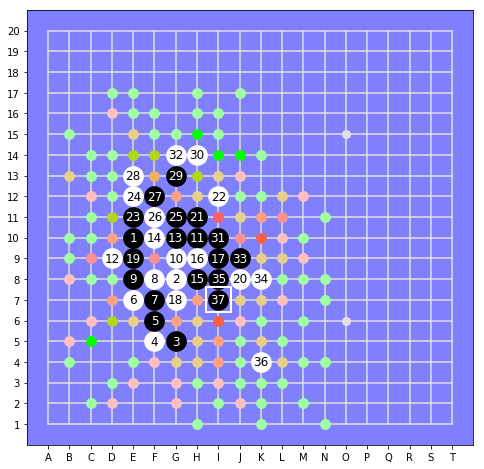

In [5]:
stones = gt.string_to_stones('e10g8g5f5f6e7f7f8e8g9h10d9g10f10h8h9i9g7e9j8h11i12e11e12g11f11f12e13g13h14i10g14j9k8i8k4i7')

b = GomokuBoard(heuristics=Heuristics(kappa=3), N=20, stones=stones, disp_width=8)
b.display('current')

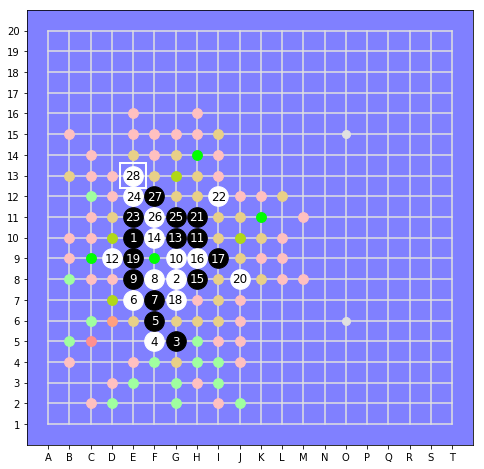

In [6]:
from copy import deepcopy
board = deepcopy(b)
(board.undo().undo().undo().undo().undo().undo().undo().undo().undo()
# .undo().undo().undo().undo().undo().undo().undo().undo()
)
board.display('current')

In [7]:
moves, won = ThreatSearch(11,10).is_tseq_won(board)
moves, won

([(7, 13),
  (4, 10),
  (8, 14),
  (9, 15),
  (8, 12),
  (8, 13),
  (10, 10),
  (9, 11),
  (11, 11),
  (12, 12),
  (9, 13),
  (10, 12),
  (10, 14),
  (11, 15),
  (7, 14),
  (9, 14),
  (7, 12),
  (7, 15),
  (9, 10),
  (10, 9),
  (5, 14)],
 True)

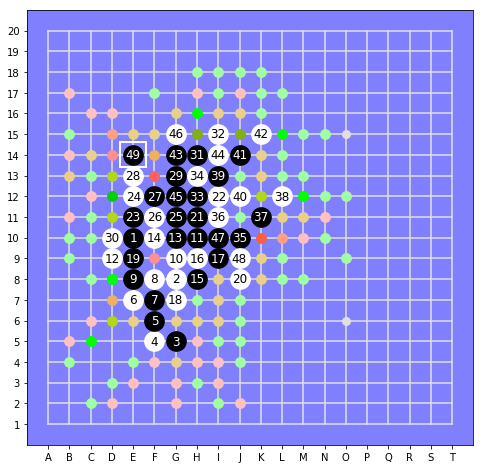

In [8]:
threat_sequence = deepcopy(board)
for x,y in moves:
    threat_sequence.set(x,y)
threat_sequence.display('current')

In [29]:
HeuristicGomokuPolicy(board=threat_sequence, style=1).suggest()

Two or more immediate threats. Giving up.

## Threats from different perspectives

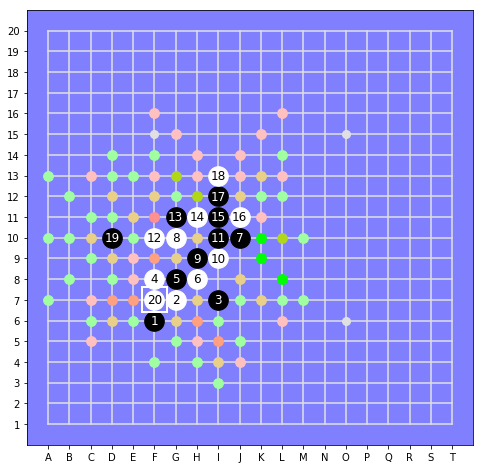

In [31]:
stones = gt.string_to_stones('f6g7i7f8g8h8j10g10h9i9i10f10g11h11i11j11i12i13d10f7')

b = GomokuBoard(heuristics=Heuristics(kappa=3), N=20, stones=stones, disp_width=8)
b.display('current')

In [34]:
ts = ThreatSearch(3,3)
moves, won = ts.is_tseq_won(b)
moves, won

([(11, 9), (8, 12), (12, 10), (11, 10), (10, 8)], True)

### A threat against me

In [37]:
#b.set(I, 14).display('current')
moves = ts.is_tseq_threat(b,3)
moves

[(11, 9), (8, 12), (12, 10), (11, 10), (10, 8)]